In [160]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [161]:
import numpy as np
import os
import mcubes
import meshcat
import pydrake
from pydrake.geometry import SceneGraph
from pydrake.systems.framework import DiagramBuilder
from pydrake.common import FindResourceOrThrow
from pydrake.multibody.plant import MultibodyPlant, AddMultibodyPlantSceneGraph
from pydrake.multibody.parsing import Parser, LoadModelDirectives, ProcessModelDirectives
from pydrake.multibody.tree import RevoluteJoint
from pydrake.all import ConnectMeshcatVisualizer, InverseKinematics, RigidTransform, RotationMatrix
from pydrake.all import BsplineTrajectoryThroughUnionOfHPolyhedra, IrisInConfigurationSpace, IrisOptions, Rgba
import time
from meshcat import Visualizer
from functools import partial

import ipywidgets as widgets
from IPython.display import display

#from meshcat_cpp_utils import StartMeshcat, MeshcatJointSliders
from pydrake.all import MeshcatVisualizerCpp, MeshcatVisualizerParams, Role
import rrt, utils, prm# spp
from iris_t_space import set_up_iris_t_space


In [162]:
# Setup meshcat
from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=[])

In [163]:
vis = Visualizer(zmq_url=zmq_url)
vis.delete()

#model_file = FindResourceOrThrow("drake/manipulation/models/iiwa_description/urdf/iiwa14_polytope_collision.urdf")
model_file = FindResourceOrThrow("drake/manipulation/models/iiwa_description/iiwa7/iiwa7_with_box_collision.sdf")

#model_file = FindResourceOrThrow("drake/manipulation/models/iiwa_description/iiwa7/iiwa7_no_collision.sdf")
#model_file = FindResourceOrThrow("drake/manipulation/models/iiwa_description/sdf/iiwa14_no_collision.sdf")

#box_file = FindResourceOrThrow("drake/sandbox/assets/box.urdf")
box_file_1 = FindResourceOrThrow("drake/sandbox/assets/shelves.sdf")
box_file_2 = FindResourceOrThrow("drake/sandbox/assets/shelves2.sdf")
box_file_3 = FindResourceOrThrow("drake/sandbox/assets/shelves3.sdf")
box_file_4 = FindResourceOrThrow("drake/sandbox/assets/shelves4.sdf")
lid_file = FindResourceOrThrow("drake/sandbox/assets/lid.urdf")
ground_file = FindResourceOrThrow("drake/sandbox/assets/ground.urdf")

models =[]

builder = DiagramBuilder()

plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
models.append(Parser(plant, scene_graph).AddModelFromFile(model_file))

# models.append(Parser(plant, scene_graph).AddModelFromFile(box_file_1))
# models.append(Parser(plant, scene_graph).AddModelFromFile(box_file_2))
# models.append(Parser(plant, scene_graph).AddModelFromFile(box_file_3))
# models.append(Parser(plant, scene_graph).AddModelFromFile(box_file_4))
# models.append(Parser(plant, scene_graph).AddModelFromFile(lid_file))
# models.append(Parser(plant, scene_graph).AddModelFromFile(ground_file))

sp = 0.45
x_fac = 1.25
locs = [ [0,0,0], 
        [x_fac*sp, 1.4*sp,0.4], [x_fac*sp,-1.4*sp,0.4], [-x_fac*sp,-1.4*sp,0.4], [-x_fac*sp,1.4*sp,0.4], 
        [0.0 ,0 , 0.95], [0.0 ,0 , -0.08]] 
idx = 0
for model in models:
    plant.WeldFrames(plant.world_frame(), plant.get_body(plant.GetBodyIndices(model)[0]).body_frame(), RigidTransform(locs[idx]))
    idx +=1
    
    
plant.Finalize()

visualizer = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url, delete_prefix_on_load=False, )

diagram = builder.Build()
visualizer.load()
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyContextFromRoot(context)
diagram.Publish(context)



You can open the visualizer by visiting the following URL:
http://127.0.0.1:7010/static/
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6010...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7010/static/
Connected to meshcat-server.


In [164]:
sliders = []

for joint_idx in range(1,8):
    sliders.append(
        widgets.FloatSlider(
        min=plant.GetJointByName(f"iiwa_joint_{joint_idx}").position_lower_limit(), 
        max=plant.GetJointByName(f"iiwa_joint_{joint_idx}").position_upper_limit(), 
        value=0, 
        description=f'iiwa_joint_{joint_idx}'
        )
    )

ik = InverseKinematics(plant, plant_context)
collision_constraint = ik.AddMinimumDistanceConstraint(0.001, 0.001)

def eval_cons(q, c, tol):
    return 1-1*float(c.evaluator().CheckSatisfied(q, tol))
    
col_func_handle = partial(eval_cons, c=collision_constraint, tol=0.01)
    
def showres(q):
    for joint_idx in range(1,8):
        plant.GetJointByName(f"iiwa_joint_{joint_idx}").set_angle(plant_context, q[joint_idx-1])
    t = convert_q_to_t(q)
    col = col_func_handle_rational(t)
#     col = col_func_handle(q)
    if col:
        vis["collision"].set_object(
                meshcat.geometry.Sphere(0.1), meshcat.geometry.MeshLambertMaterial(color=0xFF0000))
        vis["collision"].set_transform(
                meshcat.transformations.translation_matrix([0, 1.0, 1.0]))
    else:
        vis["collision"].set_object(
                meshcat.geometry.Sphere(0.1), meshcat.geometry.MeshLambertMaterial(color=0x00FF00))
        vis["collision"].set_transform(
                meshcat.transformations.translation_matrix([0, 1.0, 1.0]))
    diagram.Publish(context)
    print("              ", end = "\r")
    print(col , end = "\r")

    
def set_joint_angles(vals):
    for idx in range(1,8):
        plant.GetJointByName(f"iiwa_joint_{idx}").set_angle(plant_context, vals[idx-1])
    
    
    
q_init = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
# q_start = [-1.37, -1.39, -1.57, -1.19, -1.57, 0.00, 0.00]
# q_end = [1.53, -1.19, 1.83, 0.91, -1.27, -0.59, 0.00]
q = q_init.copy()
def handle_slider_change(change, idx):
    q[idx] = change['new']
    #print(q, end="\r")
    showres(q)
    
idx = 0
for slider in sliders:
    slider.observe(partial(handle_slider_change, idx = idx), names='value')
    idx+=1

def convert_q_to_t(q):
    return np.tan(np.divide(q,2))

def convert_t_to_q(t):
#     q =np.arctan2(2*t/(1+t**2), (1-t**2)/(1+t**2))
    q = np.arctan2(2*t, 1-t**2)
    return q

def eval_cons_rational(t, c, tol):
    q = convert_t_to_q(t).squeeze()
    return col_func_handle(q)
   
col_func_handle_rational = partial(eval_cons_rational, c=collision_constraint, tol=0.01)



In [165]:
for slider in sliders:
    display(slider)
display(vis.jupyter_cell())

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


In [166]:
#problem config
start = np.array([1.43, -0.69, 0.83, 1.01, -1.97, 1.11, 0.00])
target = np.array([1.73, 1.41, 0.43, -1.19, -1.27, -1.19, 0.00])
showres(start)
q_limits =[plant.GetPositionLowerLimits(), plant.GetPositionUpperLimits()]
t_limits = [convert_q_to_t(q_limits[0]), convert_q_to_t(q_limits[1])]
t_start = convert_q_to_t(start)
t_target = convert_q_to_t(target)

In [167]:
showres(target)

In [168]:
showres(np.zeros(7))

In [169]:
PRM = prm.PRM( 
            t_limits,
            num_points = 30000,
            col_func_handle = col_func_handle_rational,
            num_neighbours = 30, 
            dist_thresh = 3.0,
            num_col_checks = 50,
            verbose = True,
            plotcallback = None
            )

PRM.add_start_end(t_start, t_target)
# PRM.add_start_end(start, target)
prm_path_rational, _ = PRM.find_shortest_path()
print(f'PRM path length: {len(prm_path_rational)}')

[PRM] Samples 0
[PRM] Samples 30
[PRM] Samples 60
[PRM] Samples 90
[PRM] Samples 120
[PRM] Samples 150
[PRM] Samples 180
[PRM] Samples 210
[PRM] Samples 240
[PRM] Samples 270
[PRM] Samples 300
[PRM] Samples 330
[PRM] Samples 360
[PRM] Samples 390
[PRM] Samples 420
[PRM] Samples 450
[PRM] Samples 480
[PRM] Samples 510
[PRM] Samples 540
[PRM] Samples 570
[PRM] Samples 600
[PRM] Samples 630
[PRM] Samples 660
[PRM] Samples 690
[PRM] Samples 720
[PRM] Samples 750
[PRM] Samples 780
[PRM] Samples 810
[PRM] Samples 840
[PRM] Samples 870
[PRM] Samples 900
[PRM] Samples 930
[PRM] Samples 960
[PRM] Samples 990
[PRM] Samples 1020
[PRM] Samples 1050
[PRM] Samples 1080
[PRM] Samples 1110
[PRM] Samples 1140
[PRM] Samples 1170
[PRM] Samples 1200
[PRM] Samples 1230
[PRM] Samples 1260
[PRM] Samples 1290
[PRM] Samples 1320
[PRM] Samples 1350
[PRM] Samples 1380
[PRM] Samples 1410
[PRM] Samples 1440
[PRM] Samples 1470
[PRM] Samples 1500
[PRM] Samples 1530
[PRM] Samples 1560
[PRM] Samples 1590
[PRM] Samples

[PRM] Samples 12840
[PRM] Samples 12870
[PRM] Samples 12900
[PRM] Samples 12930
[PRM] Samples 12960
[PRM] Samples 12990
[PRM] Samples 13020
[PRM] Samples 13050
[PRM] Samples 13080
[PRM] Samples 13110
[PRM] Samples 13140
[PRM] Samples 13170
[PRM] Samples 13200
[PRM] Samples 13230
[PRM] Samples 13260
[PRM] Samples 13290
[PRM] Samples 13320
[PRM] Samples 13350
[PRM] Samples 13380
[PRM] Samples 13410
[PRM] Samples 13440
[PRM] Samples 13470
[PRM] Samples 13500
[PRM] Samples 13530
[PRM] Samples 13560
[PRM] Samples 13590
[PRM] Samples 13620
[PRM] Samples 13650
[PRM] Samples 13680
[PRM] Samples 13710
[PRM] Samples 13740
[PRM] Samples 13770
[PRM] Samples 13800
[PRM] Samples 13830
[PRM] Samples 13860
[PRM] Samples 13890
[PRM] Samples 13920
[PRM] Samples 13950
[PRM] Samples 13980
[PRM] Samples 14010
[PRM] Samples 14040
[PRM] Samples 14070
[PRM] Samples 14100
[PRM] Samples 14130
[PRM] Samples 14160
[PRM] Samples 14190
[PRM] Samples 14220
[PRM] Samples 14250
[PRM] Samples 14280
[PRM] Samples 14310


KeyboardInterrupt: 

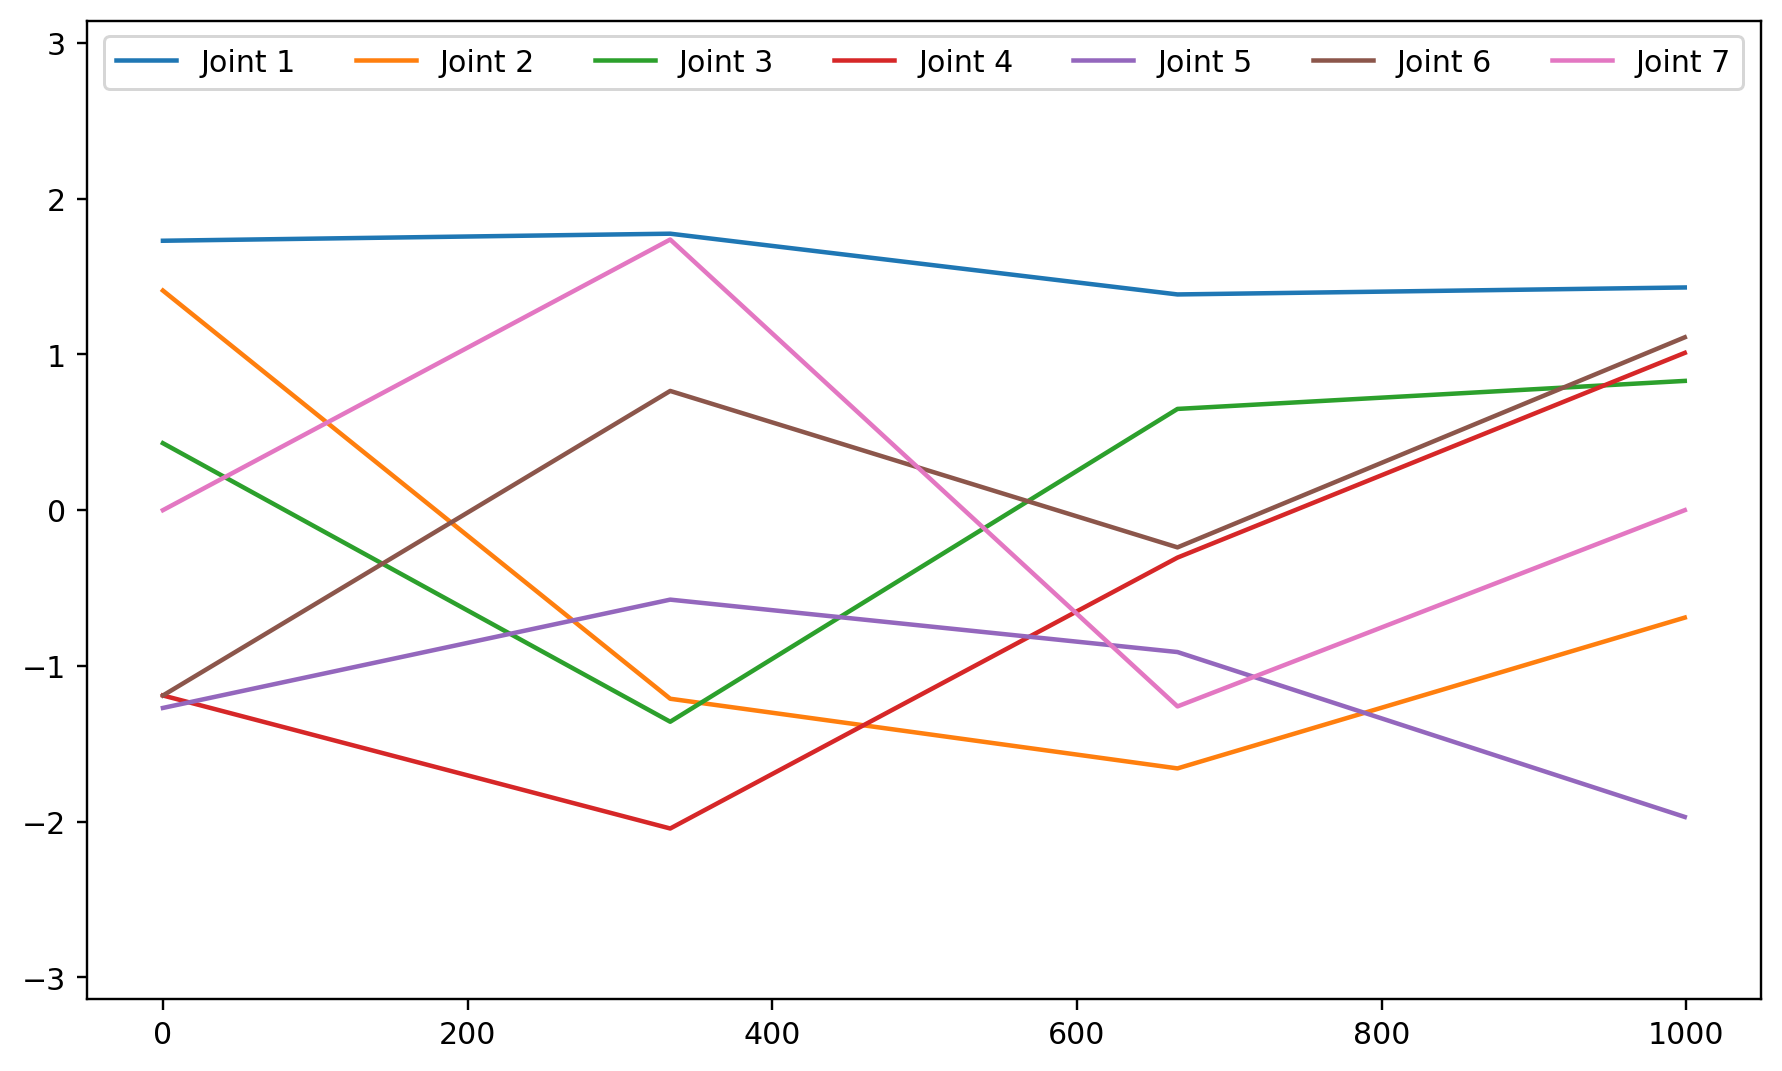

In [132]:
prm_path = [convert_t_to_q(t) for t in prm_path_rational]
prm_traj= utils.PWLinTraj(prm_path, 5.0)
substeps = 1000
utils.plot(prm_traj, substeps, 1*substeps)
utils.animate(prm_traj, showres, substeps, 1*substeps)

In [133]:
print(f'PRM path shape: {np.array(prm_path).shape}')
subsampled_prm_path = prm_path[1:-1]
print(f'PRM path shape subsampled for IRIS seed points: {np.array(subsampled_prm_path).shape}')

PRM path shape: (4, 7)
PRM path shape subsampled for IRIS seed points: (2, 7)


In [171]:
RRT = rrt.RRT(start = t_start,
              goal = t_target,
              limits = t_limits,
              col_func_handle=col_func_handle_rational,
              max_extend_length=0.01,
              extend_steps=0.005,
              init_goal_sample_rate=0.03,
              goal_sample_rate_scaler=0.6,
              verbose = True, 
              plotcallback = None)

_, rrt_path_rational = RRT.run(30000)
print(f'RRT path length: {len(rrt_path_rational)}')

0
it: 0 distance to target:  2.322 goalsample prob:  0.030
it: 2 distance to target:  2.322 goalsample prob:  0.030
it: 4 distance to target:  2.320 goalsample prob:  0.030
it: 10 distance to target:  2.315 goalsample prob:  0.030
it: 16 distance to target:  2.314 goalsample prob:  0.030
it: 18 distance to target:  2.313 goalsample prob:  0.030
it: 36 distance to target:  2.311 goalsample prob:  0.030
it: 84 distance to target:  2.309 goalsample prob:  0.030
it: 93 distance to target:  2.304 goalsample prob:  0.030
it: 116 distance to target:  2.299 goalsample prob:  0.030
it: 127 distance to target:  2.294 goalsample prob:  0.030
it: 135 distance to target:  2.289 goalsample prob:  0.030
it: 184 distance to target:  2.284 goalsample prob:  0.030
it: 188 distance to target:  2.279 goalsample prob:  0.030
it: 231 distance to target:  2.277 goalsample prob:  0.030
it: 239 distance to target:  2.272 goalsample prob:  0.030
it: 265 distance to target:  2.267 goalsample prob:  0.030
it: 272

KeyboardInterrupt: 

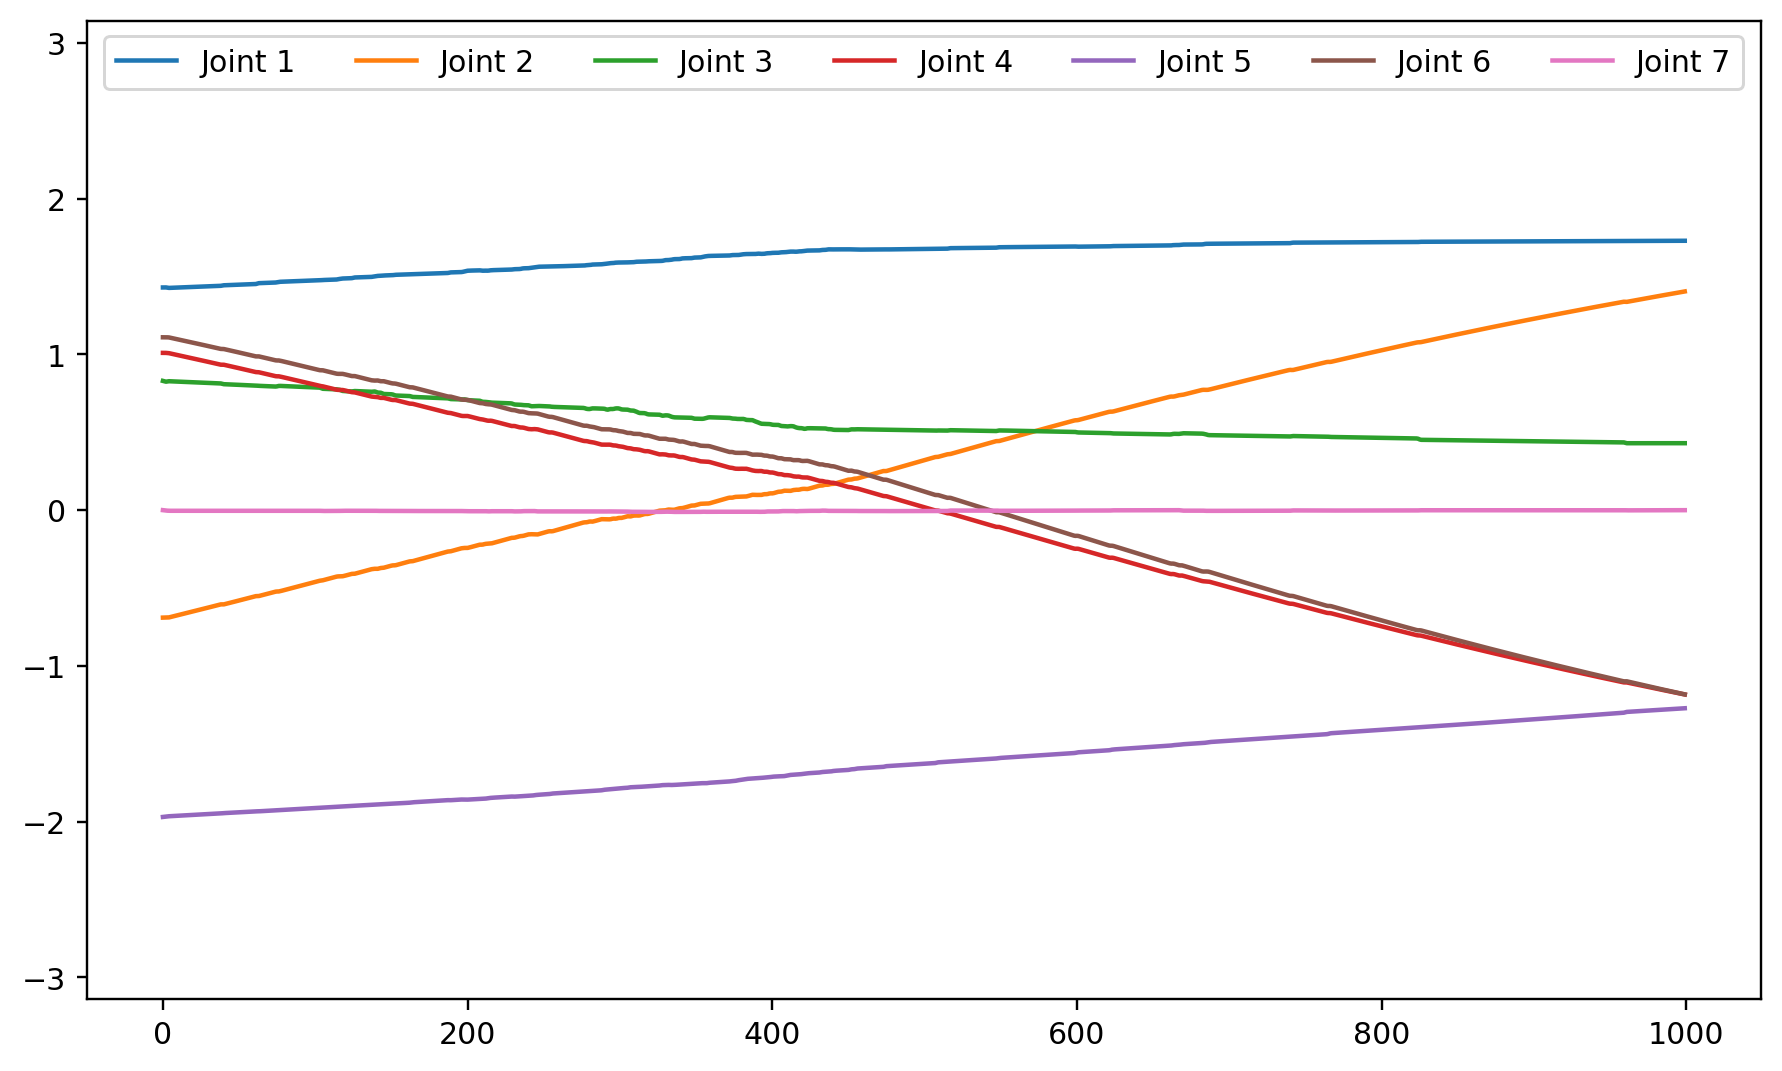

In [159]:
rrt_path = [convert_t_to_q(t) for t in rrt_path_rational]
rrt_traj= utils.PWLinTraj(rrt_path, 5.0)
substeps = 1000
utils.animate(rrt_traj, showres, substeps, 2*substeps)
utils.plot(rrt_traj, substeps, 1*substeps)

In [ ]:
print(f'RRT path shape: {np.array(rrt_path).shape}')
subsampled_rrt_path = rrt_path[1:-1:10]
print(f'RRT path shape subsampled for IRIS seed points: {np.array(subsampled_rrt_path).shape}')

In [ ]:
def do_iris(q_seed, iris_options):
    start_time = time.time()
    hpoly = IrisInConfigurationSpace(plant, plant_context, q_seed, iris_options)
    ellipse = hpoly.MaximumVolumeInscribedEllipsoid()
    print("Time: %6.2f \tVolume: %6.2f \tCenter:" % (time.time() - start_time, ellipse.Volume()),
          ellipse.center(), flush=True)
    return ellipse, hpoly

iris_options = IrisOptions()
iris_options.require_sample_point_is_contained = True
iris_options.iteration_limit = 50
iris_options.enable_ibex = False

regions = []
ellipses = []
its = 40
# seed_points = rrt_path
# seed_points = [start] + subsampled_rrt_path + [target]
seed_points = [start] + subsampled_prm_path + [target]
# seed_points = [start, target]


# for point in seed_points:
#     ell, reg = do_iris(point, iris_options)
#     regions.append(reg)
#     ellipses.append(ell)
    
# for it in range(its):
#     print(f'Iteration {it}/{its-1}')
#     #rejection sampling to get initial feasible point 
#     found = False
#     while not found:
#         t = np.random.rand(len(limits[0]))
#         q_samp = (1-t)*limits[0] + t*limits[1]
#         found = (col_func_handle(q_samp)==0.0)
#     print("point found: ", q_samp)
#     ell, reg = do_iris(q_samp, iris_options)
#     if ell.Volume() < 1000.0:
#         regions.append(reg)
#         ellipses.append(ell)
        
#         set_joint_angles(ell.center())
#         tf = plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(6)))
#         mat = meshcat.geometry.MeshLambertMaterial(color=0x0029F1)
#         mat.reflectivity = 1.0
#         vis['centers']['points' + str(it)].set_object(
#                     meshcat.geometry.Sphere(0.02), mat)
#         vis['centers']['points' + str(it)].set_transform(tf.GetAsMatrix4())

it = 0
for point in seed_points:
    ell, reg = do_iris(point, iris_options)
    
    if ell.Volume() < 1000.0:
        regions.append(reg)
        ellipses.append(ell)
        
        set_joint_angles(ell.center())
        tf = plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(6)))
        mat = meshcat.geometry.MeshLambertMaterial(color=0x0029F1)
        mat.reflectivity = 1.0
        vis['centers']['points' + str(it)].set_object(
                    meshcat.geometry.Sphere(0.02), mat)
        vis['centers']['points' + str(it)].set_transform(tf.GetAsMatrix4())
    it += 1

In [ ]:
start_time = time.time()
spp = BsplineTrajectoryThroughUnionOfHPolyhedra(start, target, regions)
spp.set_max_velocity(.8 * np.ones(7))
spp.set_extra_control_points_per_region(2)

print(spp.num_regions())
traj = spp.Solve()
print(time.time() - start_time)
print(traj)

print(traj.start_time())
print(traj.end_time())
#visualize
maxit = 60
pts = []
for it in range(maxit):
    print(f'Iteration {it}/{maxit-1}')
    pts.append(traj.value(it*traj.end_time()/maxit))
    mat = meshcat.geometry.MeshLambertMaterial(color=0xFFF812)
    mat.reflectivity = 1.0
    set_joint_angles(pts[-1].reshape(-1,))
    tf= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(3)))
   
     
    mat = meshcat.geometry.MeshLambertMaterial(color=0x0029F1)
    mat.reflectivity = 1.0
    vis['traj']['points' + str(it)].set_object(
                meshcat.geometry.Sphere(0.02), mat)
    vis['traj']['points' + str(it)].set_transform(
                meshcat.transformations.translation_matrix(tf.translation()))
    

In [ ]:
pts = []
for it in range(100):
    pts.append(traj.value(it*traj.end_time()/maxit))
    mat = meshcat.geometry.MeshLambertMaterial(color=0xFFF812)
    mat.reflectivity = 1.0
    set_joint_angles(pts[-1].reshape(-1,))
    tf= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(3)))
   
     
    mat = meshcat.geometry.MeshLambertMaterial(color=0x0029F1)
    mat.reflectivity = 1.0
    vis['traj']['points' + str(it)].set_object(
                meshcat.geometry.Sphere(0.02), mat)
    vis['traj']['points' + str(it)].set_transform(
                meshcat.transformations.translation_matrix(tf.translation()))

In [ ]:
# traj
substeps = 1000
utils.animate(traj, showres, substeps, 5*substeps)
utils.plot(traj, substeps, 1*substeps)

In [ ]:
# Manual reversal of IRIS trajectory

import matplotlib.pyplot as plt

#loop
idx = 0
going_fwd = True
time_points BsplineTrajectoryThroughUnionOfHPolyhedra= np.linspace(0, traj.end_time(), substeps) 

for _ in range(substeps):
    #print(idx)
    q = traj.value(time_points[substeps-idx-1])
    showres(q.reshape(-1,))
    if going_fwd:
        if idx + 1 < substeps:
            idx += 1
        else:
            going_fwd = False
            idx -=1
    else:
        if idx-1 >= 0:
            idx -=1
        else:
            going_fwd = True
            idx +=1


#loop
idx = 0
going_fwd = True
time_points = np.linspace(0, traj.end_time(), substeps) 
traj_list = []

for _ in range(substeps):
    #print(idx)
    traj_list.append(traj.value(time_points[substeps-idx-1]).reshape(-1,))
    if going_fwd:
        if idx + 1 < substeps:
            idx += 1
        else:
            going_fwd = False
            idx -=1
    else:
        if idx-1 >= 0:
            idx -=1
        else:
            going_fwd = True
            idx +=1

traj_arr = np.array(traj_list)

fig, ax = plt.subplots(1,1, figsize=(10,6), dpi=72*3)
data_dims = traj_arr.shape[1]
for joint_idx in range(data_dims):
    ax.plot(np.arange(len(traj_arr[:,joint_idx])),traj_arr[:,joint_idx], label=f'Joint {joint_idx+1}')
ax.legend(loc='upper center', ncol=data_dims)
ax.set_ylim([-np.pi, np.pi])
plt.show()

In [ ]:
import spp


In [ ]:
from pydrake.geometry.optimization import 
